# Import Libraries

In [13]:
import tensorflow as tf 
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

In [17]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

## Load train dataset

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1695 files belonging to 4 classes.


# Load test dataset

In [7]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/test",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 246 files belonging to 4 classes.


# Load Validation dataset

In [8]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/valid",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 502 files belonging to 4 classes.


In [9]:
class_names = train_dataset.class_names
n_classes = len(class_names)

# Print ClassNames

In [10]:
class_names

['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Number of Classes Present

In [11]:
n_classes

4

# Prepare Datasets for Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Load a Pretrained Models

In [14]:
def build_model(base_model_fn, model_name):
    print(f"\nBuilding model: {model_name}")
    base_model = base_model_fn(
        input_shape=IMAGE_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze base model

    inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name=model_name)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


 # List of Pretrained Models to Try

In [15]:
pretrained_models = {
    "MobileNetV2": MobileNetV2,
    "ResNet50": ResNet50,
    "EfficientNetB0": EfficientNetB0
}

# Train Each Model and Collect Results

In [18]:
histories = {}
val_accuracies = {}

for name, base_model_fn in pretrained_models.items():
    model = build_model(base_model_fn, name)
    
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
    
    print(f"Training {name}...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[early_stop],
        verbose=1
    )

    val_acc = max(history.history["val_accuracy"])
    val_accuracies[name] = val_acc
    histories[name] = history
    print(f"{name} max val_accuracy: {val_acc:.4f}")


Building model: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training MobileNetV2...
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 55s 966ms/step - accuracy: 0.4302 - loss: 1.3086 - val_accuracy: 0.7610 - val_loss: 0.6114
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 898ms/step - accuracy: 0.7619 - loss: 0.6487 - val_accuracy: 0.7729 - val_loss: 0.5371
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 922ms/step - accuracy: 0.7987 - loss: 0.5759 - val_accuracy: 0.7908 - val_loss: 0.5043
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 936ms/step - accuracy: 0.8201 - loss: 0.5121 - val_accuracy: 0.8028 - val_loss: 0.4668
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 890ms/step - accuracy: 0.8357 - loss: 0.4439 - val_accuracy: 0.8367 - val_loss: 0.4244
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 862ms/step - accuracy: 0.8541 - loss: 0.4191 - val_accuracy: 0.8546 - val_loss: 0.4043
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 894ms/step - accuracy: 0.8563 - loss: 0.3938 - val_accuracy: 0.8506 - val_loss: 0.

# Get the best Model

In [19]:
best_model_name = max(val_accuracies, key=val_accuracies.get)
print(f"\n Best model is: {best_model_name} with validation accuracy: {val_accuracies[best_model_name]:.4f}")


 Best model is: ResNet50 with validation accuracy: 0.9323


# Rebuild the Best Model (for test + fine-tuning)

In [20]:
def build_model(base_model_fn, model_name, trainable=False):
    print(f"\nBuilding model: {model_name}")
    base_model = base_model_fn(
        input_shape=IMAGE_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = trainable  # Control trainable param

    inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
    x = base_model(inputs, training=not trainable)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name=model_name)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Re-evaluate Best Model on Test Data

In [21]:
# Rebuild best model (frozen)
best_model = build_model(pretrained_models[best_model_name], best_model_name, trainable=False)

# Train briefly (for consistent weights)
best_model.fit(train_dataset, validation_data=val_dataset, epochs=5)

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test Accuracy (frozen): {test_acc:.4f}")



Building model: ResNet50
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4888 - loss: 1.2454 - val_accuracy: 0.8526 - val_loss: 0.4235
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8159 - loss: 0.4861 - val_accuracy: 0.8845 - val_loss: 0.3312
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8598 - loss: 0.3676 - val_accuracy: 0.8964 - val_loss: 0.3321
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9067 - loss: 0.2944 - val_accuracy: 0.9004 - val_loss: 0.3076
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9059 - loss: 0.2794 - val_accuracy: 0.9104 - val_loss: 0.2810
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9105 - loss: 0.2628
Test Accuracy (frozen): 0.9146


# Fine-Tune the Best Model

In [22]:
# Unfreeze top layers for fine-tuning
fine_tune_at = 100

base_model = best_model.layers[1]  # Get base model from sequential
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with low learning rate for fine-tuning
best_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Fine-tune training
fine_tune_history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

# Final test accuracy
test_loss_ft, test_acc_ft = best_model.evaluate(test_dataset)
print(f"Test Accuracy (fine-tuned): {test_acc_ft:.4f}")

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8027 - loss: 0.5796 - val_accuracy: 0.8327 - val_loss: 0.4521
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9521 - loss: 0.1530 - val_accuracy: 0.9084 - val_loss: 0.2608
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9749 - loss: 0.0854 - val_accuracy: 0.9422 - val_loss: 0.2093
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9935 - loss: 0.0471 - val_accuracy: 0.9482 - val_loss: 0.1904
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9987 - loss: 0.0285 - val_accuracy: 0.9462 - val_loss: 0.1931
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9413 - loss: 0.1655
Test Accuracy (fine-tuned): 0.9390


 # Compare Before & After Fine-Tuning

In [23]:
print(f"Before fine-tuning test acc: {test_acc:.4f}")
print(f"After fine-tuning  test acc: {test_acc_ft:.4f}")

Before fine-tuning test acc: 0.9146
After fine-tuning  test acc: 0.9390


# Extract metrics from fine-tuning history

In [27]:
acc = fine_tune_history.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']
epochs_ran = len(acc)

## Accuracy and Validation Plot

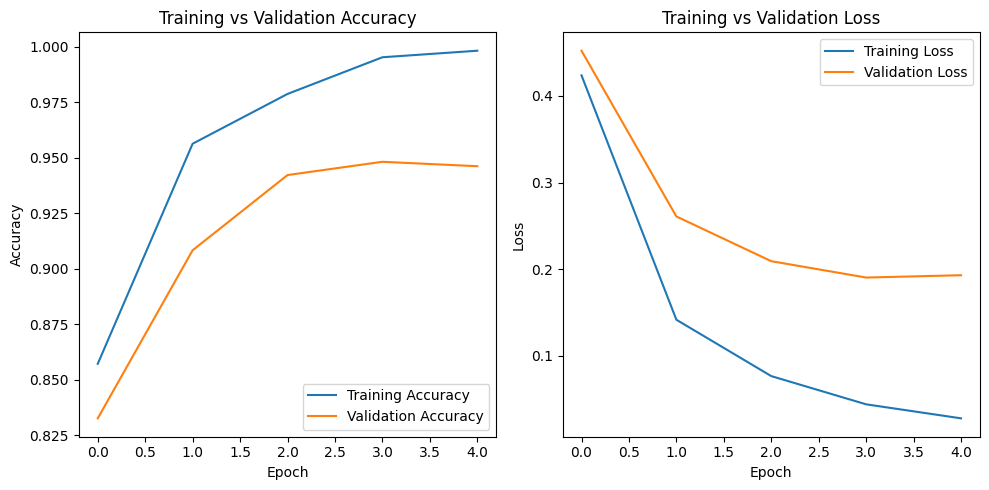

In [28]:
plt.figure(figsize=(10, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs_ran), acc, label='Training Accuracy')
plt.plot(range(epochs_ran), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs_ran), loss, label='Training Loss')
plt.plot(range(epochs_ran), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Purpose: Visual Inference and Debugging
### This block of code helps to:

- Display a real test image from your dataset.
- Print the actual label of that image.
- Use your model to predict the label for the image.
- Compare predicted vs actual label to visually verify model correctness.

First image to predict:


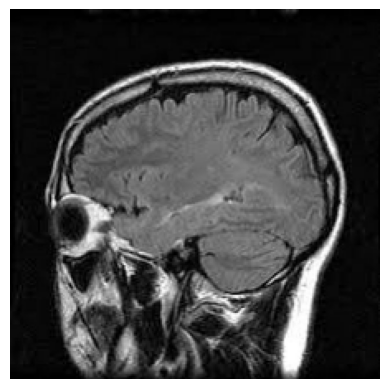

Actual label: no_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: no_tumor


In [29]:
import numpy as np
# Iterate through one batch from the test dataset
for images_batch, labels_batch in test_dataset.take(1):
    
    # Extract first image and label
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    # Show image
    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis('off')  # Hide axis for cleaner display
    plt.show()

    print("Actual label:", class_names[first_label])

    # Make prediction using fine-tuned best model
    batch_prediction = best_model.predict(images_batch)
    predicted_class = class_names[np.argmax(batch_prediction[0])]

    print("Predicted label:", predicted_class)

#  Predict a single image

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array, verbose=0)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

# Display 9 images with predictions

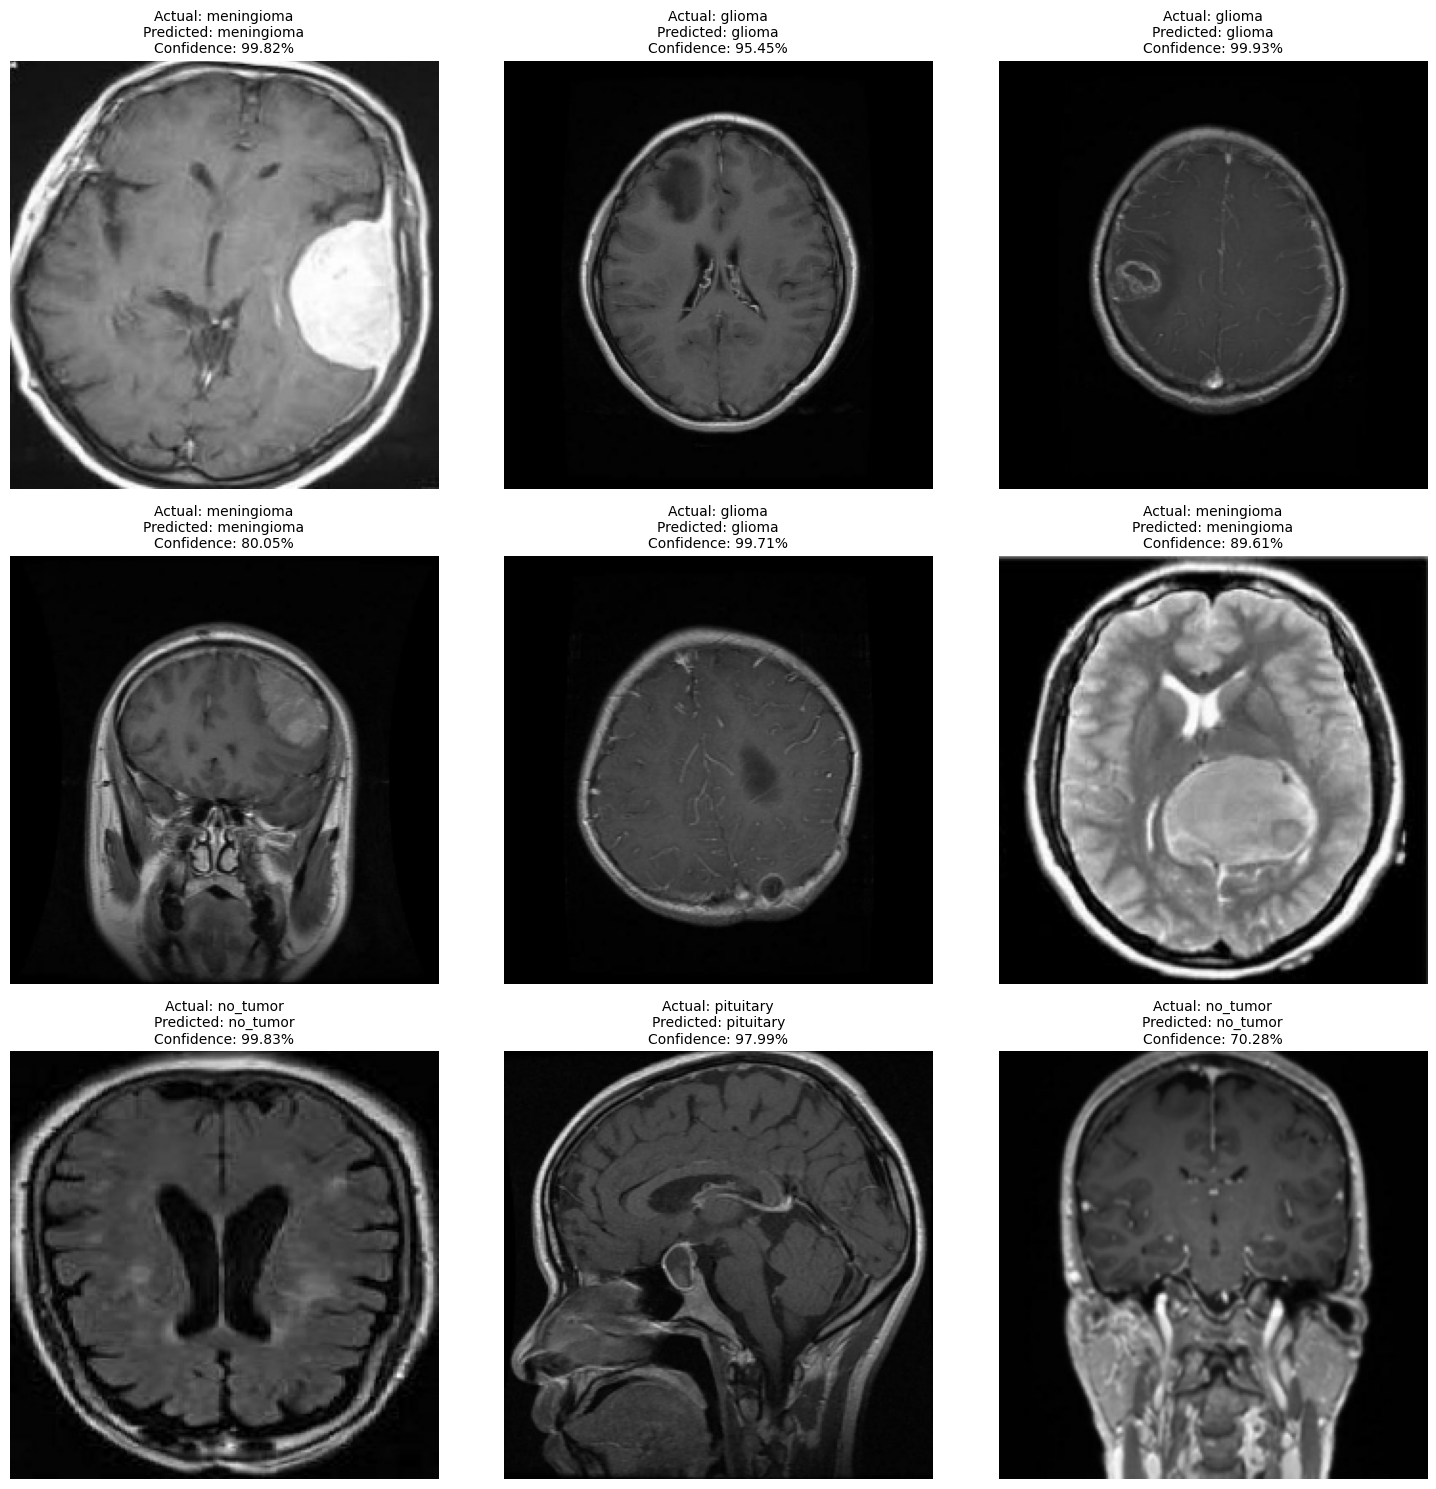

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(best_model, images[i])
        actual_class = class_names[labels[i].numpy()]
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

# Save Predicted Grid Image

In [32]:
plt.savefig("../results/predictions_grid.png")

<Figure size 640x480 with 0 Axes>

# Save Final Best Model

In [ ]:
best_model.save(f"{best_model_name}_(Transfer_Learning)_fine_tuned_model.keras")
print(f"Model saved as: {best_model_name}_(Transfer_Learning)_fine_tuned_model.keras")

Model saved as: ResNet50_fine_tuned_model.h5


# Conclusion --- 
```
Conclusion: Transfer Learning for Image Classification
In this project, we successfully implemented a transfer learning pipeline to classify images using state-of-the-art pretrained CNN architectures. The overall goal was to leverage powerful models trained on large datasets (like ImageNet) and adapt them to our domain-specific dataset (e.g., brain tumor or potato disease classification) with minimal training from scratch.

We began by loading and preparing the image data using image_dataset_from_directory(), organizing it into training, validation, and test sets. Data performance was optimized using TensorFlow’s AUTOTUNE prefetching.

Next, we explored and trained three widely used pretrained models:

- MobileNetV2

- ResNet50

- EfficientNetB0

Each model was built using a frozen base, combined with a custom classification head. After training them for a few epochs, we recorded their validation accuracies to identify the best performer.

From the results, the best model was selected based on highest validation accuracy. This best model was then:

- Evaluated on the test set to verify its generalization performance.

- Fine-tuned by unfreezing a portion of the pretrained base model and training with a lower learning rate.

- Re-evaluated to confirm improvements after fine-tuning.

Finally, the best fine-tuned model was saved for deployment, ensuring it can be reused or served via an API in production environments. 
```